In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("./data/train.csv")

In [3]:
data.head(10)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
5,FDP36,10.395,Regular,0.000000,Baking Goods,51.4008,OUT018,2009,Medium,Tier 3,Supermarket Type2,556.6088
6,FDO10,13.650,Regular,0.012741,Snack Foods,57.6588,OUT013,1987,High,Tier 3,Supermarket Type1,343.5528
7,FDP10,NaN,Low Fat,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636
8,FDH17,16.200,Regular,0.016687,Frozen Foods,96.9726,OUT045,2002,NaN,Tier 2,Supermarket Type1,1076.5986
9,FDU28,19.200,Regular,0.094450,Frozen Foods,187.8214,OUT017,2007,NaN,Tier 2,Supermarket Type1,4710.5350


In [4]:
print(f"Number of Features : {data.shape[1]}")
print(f"Number of Observations : {data.shape[0]}")

Number of Features : 12
Number of Observations : 8523


In [5]:
print('Number of Numerical Features :',data.dtypes[data.dtypes!=object].size)
print('Number of Categorial Features :',data.dtypes[data.dtypes==object].size)
print("Categorical Features: ",data.dtypes[data.dtypes==object])

Number of Numerical Features : 5
Number of Categorial Features : 7
Categorical Features:  Item_Identifier         object
Item_Fat_Content        object
Item_Type               object
Outlet_Identifier       object
Outlet_Size             object
Outlet_Location_Type    object
Outlet_Type             object
dtype: object


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [7]:
data.describe(include='all')


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
count,8523,7060.000000,8523,8523.000000,8523,8523.000000,8523,8523.000000,6113,8523,8523,8523.000000
unique,1559,NaN,5,NaN,16,NaN,10,NaN,3,3,4,NaN
top,FDW13,NaN,Low Fat,NaN,Fruits and Vegetables,NaN,OUT027,NaN,Medium,Tier 3,Supermarket Type1,NaN
freq,10,NaN,5089,NaN,1232,NaN,935,NaN,2793,3350,5577,NaN
mean,NaN,12.857645,NaN,0.066132,NaN,140.992782,NaN,1997.831867,NaN,NaN,NaN,2181.288914
std,NaN,4.643456,NaN,0.051598,NaN,62.275067,NaN,8.371760,NaN,NaN,NaN,1706.499616
min,NaN,4.555000,NaN,0.000000,NaN,31.290000,NaN,1985.000000,NaN,NaN,NaN,33.290000
25%,NaN,8.773750,NaN,0.026989,NaN,93.826500,NaN,1987.000000,NaN,NaN,NaN,834.247400
50%,NaN,12.600000,NaN,0.053931,NaN,143.012800,NaN,1999.000000,NaN,NaN,NaN,1794.331000
75%,NaN,16.850000,NaN,0.094585,NaN,185.643700,NaN,2004.000000,NaN,NaN,NaN,3101.296400


In [8]:
data.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

#### Drawing the distribution plots, to check for outliters later in the script

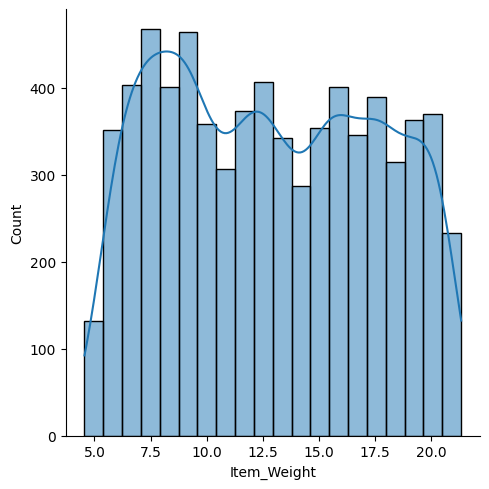

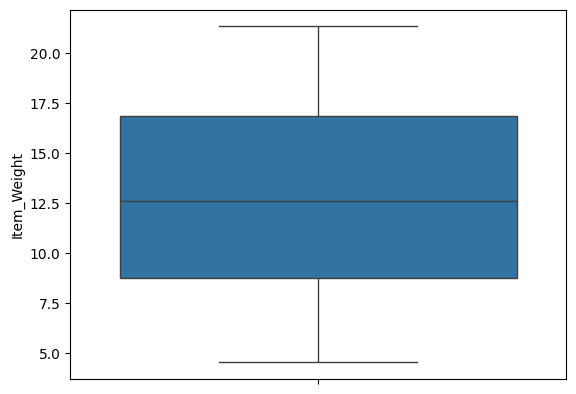

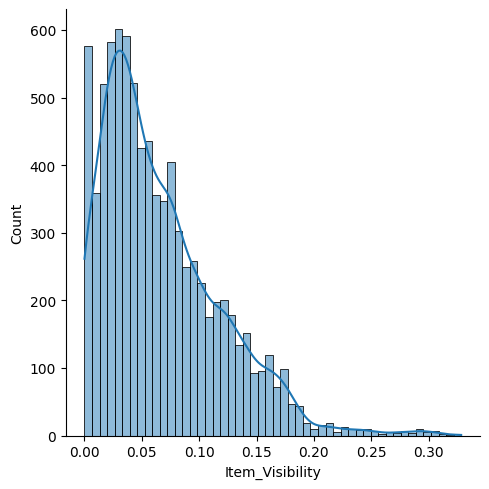

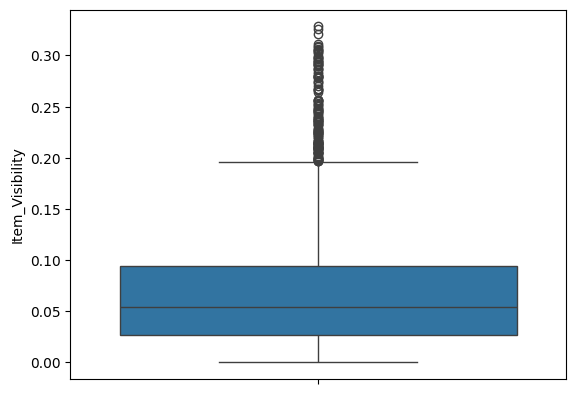

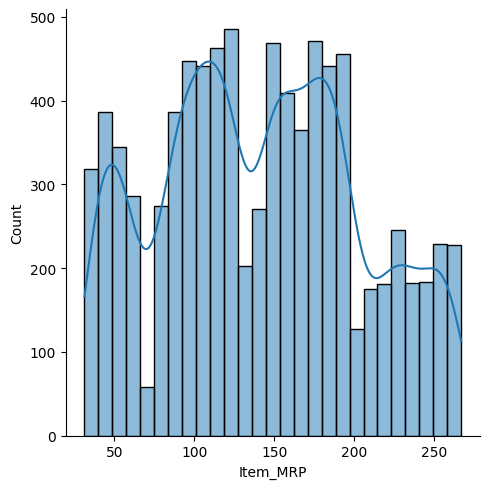

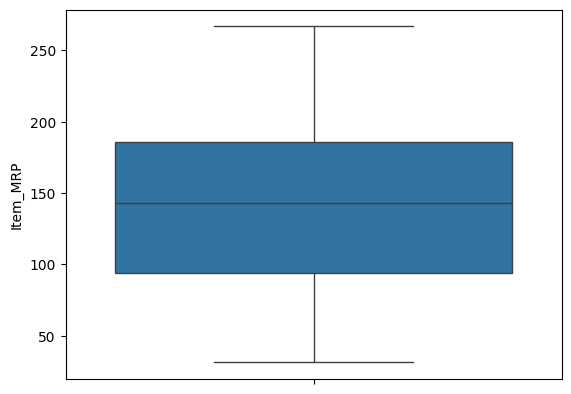

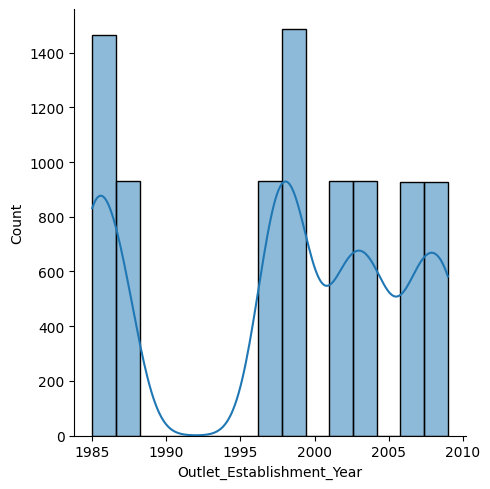

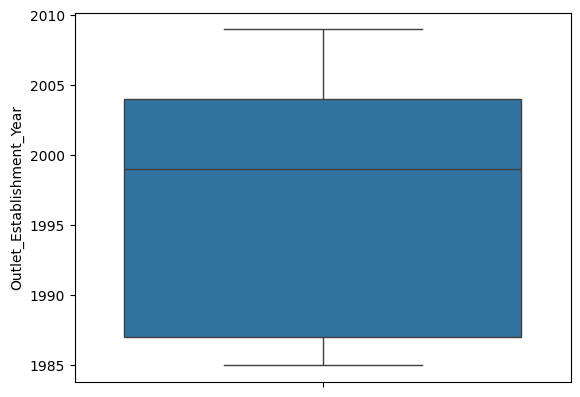

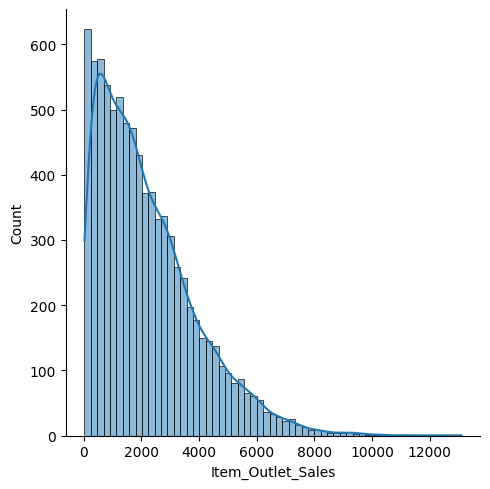

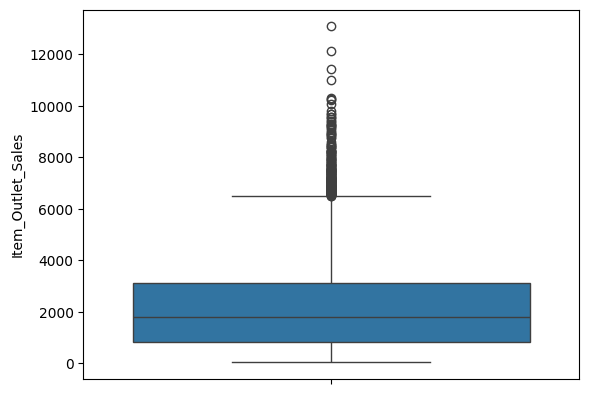

In [9]:
for i in data.select_dtypes(include="number"):
    sns.displot(data[i], kde="True")
    plt.show()
    sns.boxplot(data[i])
    plt.show()

<Axes: xlabel='count', ylabel='Item_Type'>

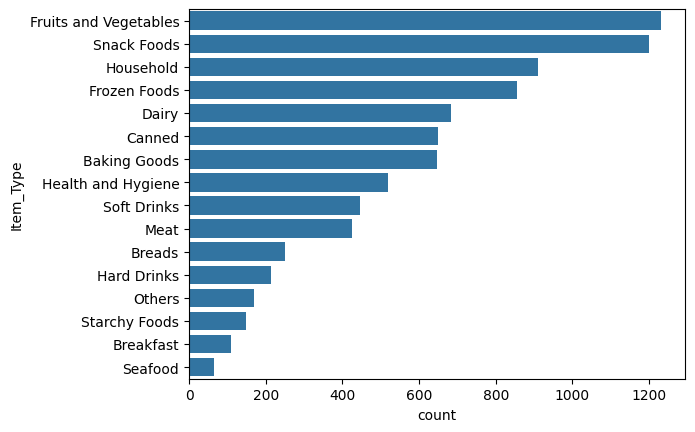

In [10]:
sns.countplot(data=data, y="Item_Type", order=data["Item_Type"].value_counts().index)

# Data preprocessing

We will begin with checking the Item_Fat_Content because that seems to be having sound suspicious unique values. There are different spellings to the same thing, which can be corrected to generalise the fat content, for example:-

- lf, low fat , LF can become Low Fat
- reg can become Regular

In [11]:
print(data["Item_Fat_Content"].unique())
data.replace(
    {"Item_Fat_Content": {"low_fat": "Low Fat", "lf": "Low Fat", "LF": "Low Fat"}},
    inplace=True,
)

data.replace({"Item_Fat_Content": {"reg": "Regular"}}, inplace=True)


print(data["Item_Fat_Content"].unique())

# One hot encoding here

['Low Fat' 'Regular' 'low fat' 'LF' 'reg']
['Low Fat' 'Regular' 'low fat']


## Treat Missing Data

### Treat the missing values for Item Weight

Since the item identifiers are duplicated in the dataset, it is possible that the weight has been entered in one observation but missing in another for the same item identifier, therefore, we are first checking what item identifiers have weights in one of the many recorded observations. We are substituting these observations with the present observation.

We also calculate what item identifiers do not have item weight in any of the recorded observations. We fill these item weight gaps using the mean of the weights of their item types. This has been supported by drawing a distribution plot for the weights of the items grouped by item types, to ensure we are not dealing with any outliers or exceptional cases, that may make our assumption erroneous. 

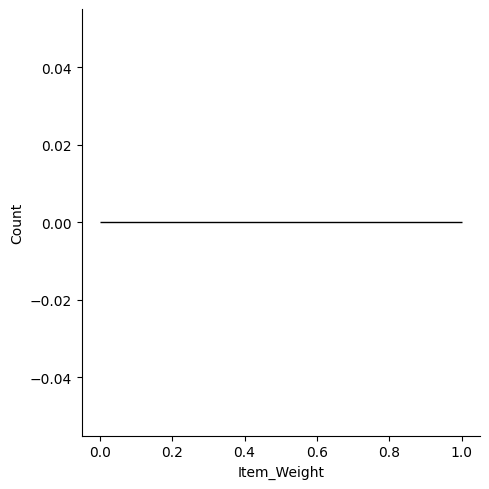

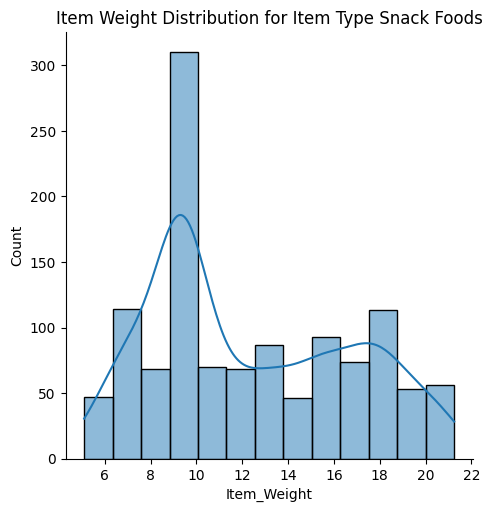

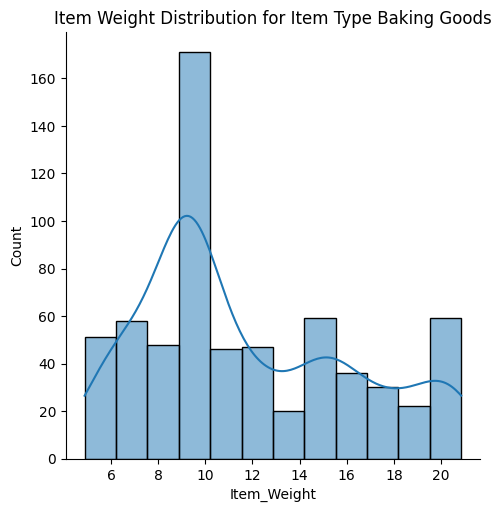

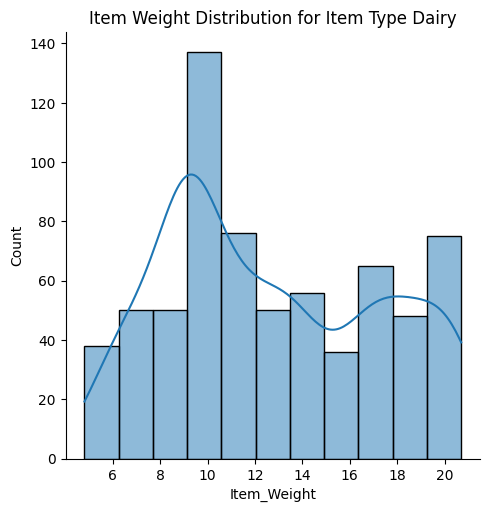

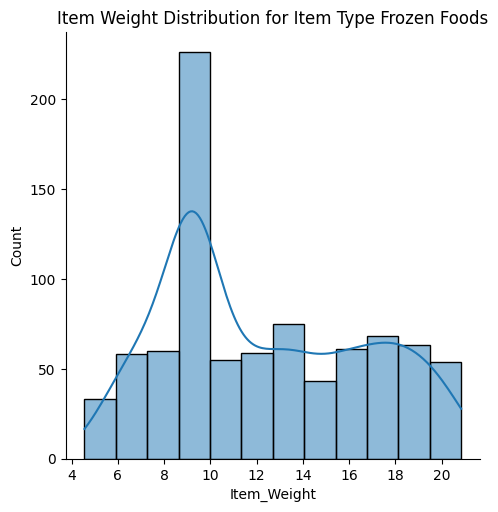

In [12]:
items_without_weight =  set(
    data.loc[data["Item_Weight"].isna()]["Item_Identifier"].unique()
)
items_with_item_weight = set(
    data.loc[-data["Item_Weight"].isna()]["Item_Identifier"].unique()
)
items_with_missing_weight = items_without_weight.intersection(
    items_with_item_weight
)

items_with_absent_weight = items_without_weight.difference(items_with_item_weight)

weight = data[
    (data["Item_Identifier"].isin(items_with_missing_weight))
    & (-data["Item_Weight"].isna())
].iloc[0]["Item_Weight"]

data.loc[
    data["Item_Identifier"].isin(items_with_missing_weight), "Item_Weight"
] = data.loc[
    data["Item_Identifier"].isin(items_with_missing_weight), "Item_Weight"
].fillna(
    weight
)


item_types = set()
item_types.update(
    set(
        data.loc[
            data["Item_Identifier"].isin(items_with_absent_weight),
            "Item_Type",
        ].unique()
    )
)
sns.displot(data=data[data["Item_Type"] == i], x="Item_Weight", kde=True)

average_weights = {}


for i in item_types:
    sns.displot(data=data[data["Item_Type"] == i], x="Item_Weight", kde=True)
    plt.title(f"Item Weight Distribution for Item Type {i}")
    average_weights[i] = data[data["Item_Type"] == i]["Item_Weight"].mean()

for i in items_with_absent_weight:
    data.loc[data["Item_Identifier"] == i, "Item_Weight"] = data.loc[
        data["Item_Identifier"] == i, "Item_Weight"
    ].fillna(
        average_weights.get(data.loc[data["Item_Identifier"] == i, "Item_Type"].iloc[0])
    )

### Treat the missing values for Outlet Size

Number of outlets that have sizes but missing in one of the rows of items: 0
Number of outlets that do not have sizes in any of the rows: 3
Outlets identifiers without any size: {'OUT045', 'OUT017', 'OUT010'}
            Outlet_Type Outlet_Location_Type Outlet_Size
3         Grocery Store               Tier 3         NaN
8     Supermarket Type1               Tier 2         NaN
9     Supermarket Type1               Tier 2         NaN
25    Supermarket Type1               Tier 2         NaN
28        Grocery Store               Tier 3         NaN
...                 ...                  ...         ...
8502  Supermarket Type1               Tier 2         NaN
8508  Supermarket Type1               Tier 2         NaN
8509      Grocery Store               Tier 3         NaN
8514  Supermarket Type1               Tier 2         NaN
8519  Supermarket Type1               Tier 2         NaN

[2410 rows x 3 columns]
['Tier 3' 'Tier 2']
['Grocery Store' 'Supermarket Type1']


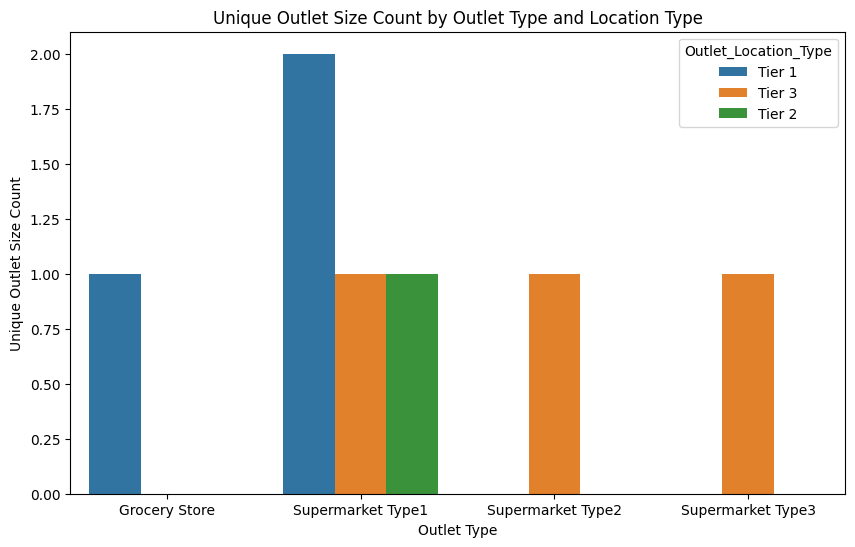

In [13]:
outlets_without_size = set(
    data.loc[data["Outlet_Size"].isna()]["Outlet_Identifier"].unique()
)
outlets_with_size = set(
    data.loc[-data["Outlet_Size"].isna()]["Outlet_Identifier"].unique()
)
outlets_with_missing_size = outlets_without_size.intersection(outlets_with_size)

outlets_with_absent_size = outlets_without_size.difference(outlets_with_size)

print(
    f"Number of outlets that have sizes but missing in one of the rows of items: {len(outlets_with_missing_size)}"
)

print(
    f"Number of outlets that do not have sizes in any of the rows: {len(outlets_with_absent_size)}"
)

print(f"Outlets identifiers without any size: {outlets_with_absent_size}")


print(
    data.loc[
        data["Outlet_Identifier"].isin(outlets_with_absent_size),
        ["Outlet_Type", "Outlet_Location_Type", "Outlet_Size"],
    ]
)

print(
    data.loc[
        data["Outlet_Identifier"].isin(outlets_with_absent_size),
        "Outlet_Location_Type",
    ].unique()
)

print(
    data.loc[
        data["Outlet_Identifier"].isin(outlets_with_absent_size),
        "Outlet_Type",
    ].unique()
)

plt.figure(figsize=(10, 6))
sns.barplot(
    x="Outlet_Type",
    y="Unique_Size_Count",
    hue="Outlet_Location_Type",
    data=data.groupby(["Outlet_Type", "Outlet_Location_Type"])["Outlet_Size"]
    .nunique()
    .reset_index(name="Unique_Size_Count"),
)
plt.title("Unique Outlet Size Count by Outlet Type and Location Type")
plt.xlabel("Outlet Type")
plt.ylabel("Unique Outlet Size Count")

outlet_type_mode = data.groupby("Outlet_Type")["Outlet_Size"].apply(lambda x: x.mode().iloc[0]).to_dict()

data["Outlet_Size"] = data["Outlet_Size"].fillna(data["Outlet_Type"].map(outlet_type_mode))



In [24]:
data.isna().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

### Encoding Categorical Data

#### One-Hot Encoding Item_Fat_Content

Should we use label encoding or one hot encoding here?

#### One-Hot Encoding Item_Type

This definitely will be one-hot encoded, since it is on a nominal scale

#### Label Encoding Outlet_Type
This definitely will be label encoded, since it is on an ordinal scale.

#### Label Encoding Outlet_Location_Type
This definitely will be label encoded, since it is on an ordinal scale. Or is it not?

#### Label Encoding Outlet_Size
This definitely will be label encoded, since it is on an ordinal scale

#### Standardise or Normalise the Outlet_Establishment_Year

# Data Visualisation

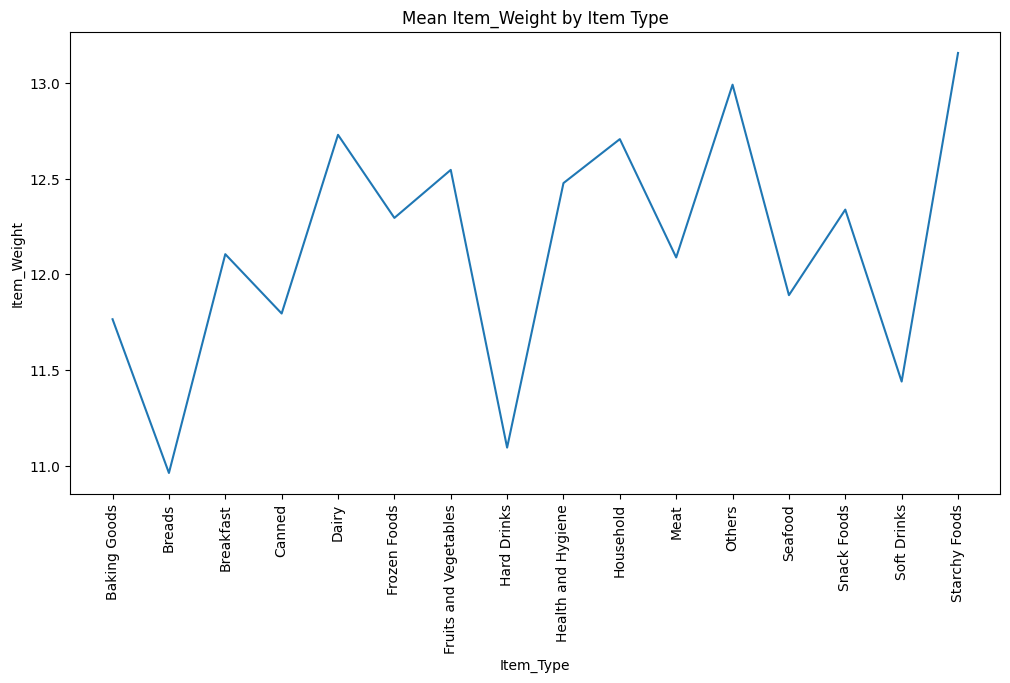

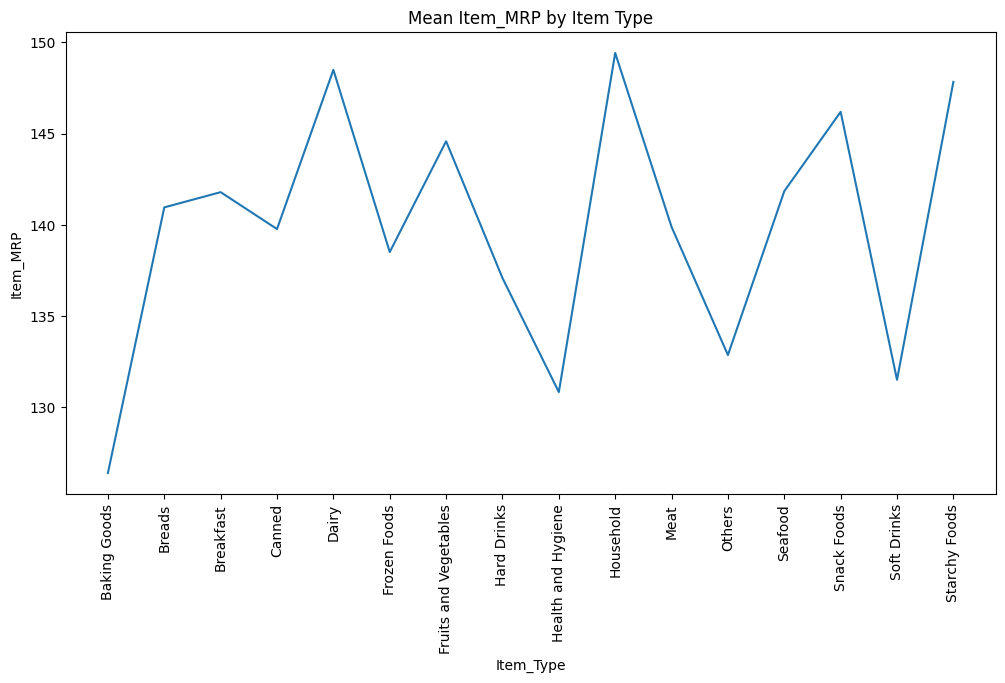

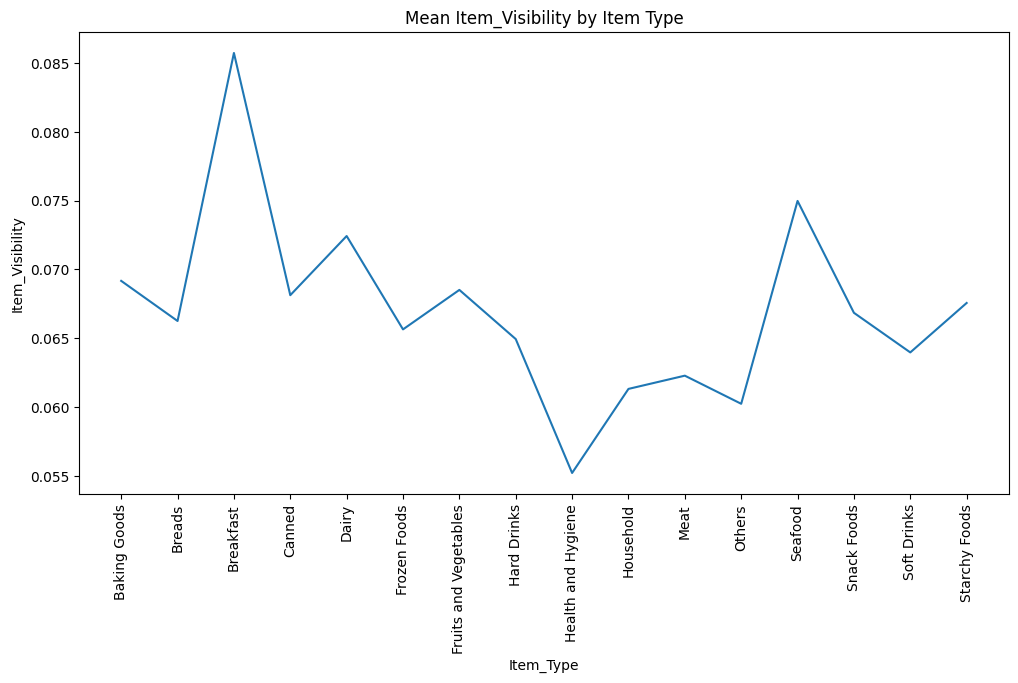

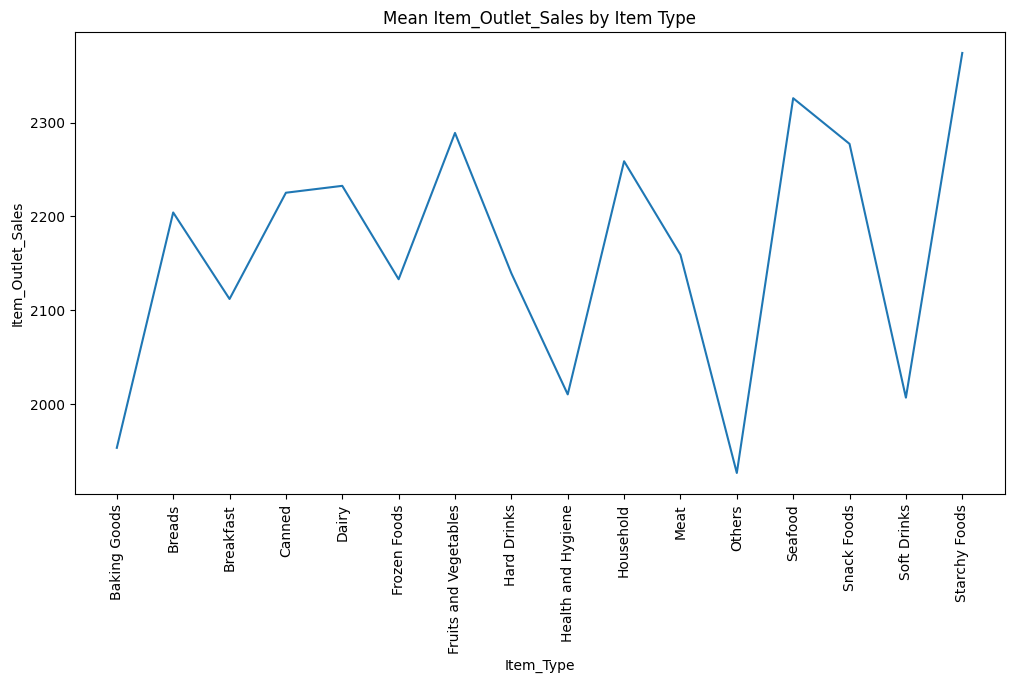

In [16]:
for i in ["Item_Weight","Item_MRP","Item_Visibility","Item_Outlet_Sales"]:
    plt.figure(figsize=(12, 6))
    sns.lineplot(x="Item_Type", y=i, data=data[["Item_Type",i]].groupby(["Item_Type"]).mean())
    plt.xticks(rotation=90)
    plt.title(f'Mean {i} by Item Type')
    plt.show()


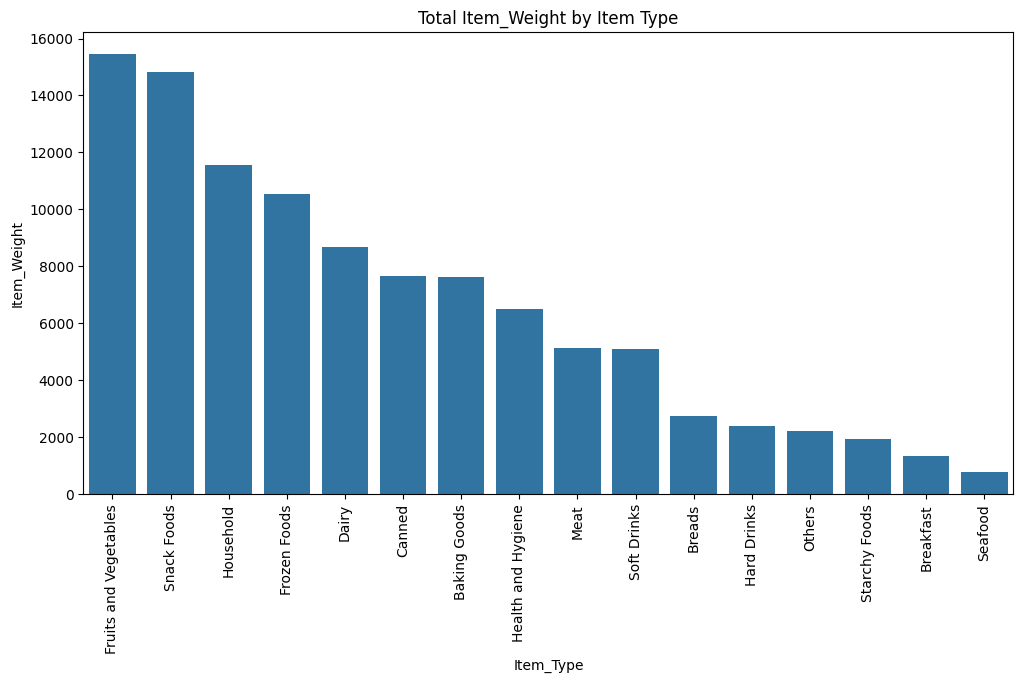

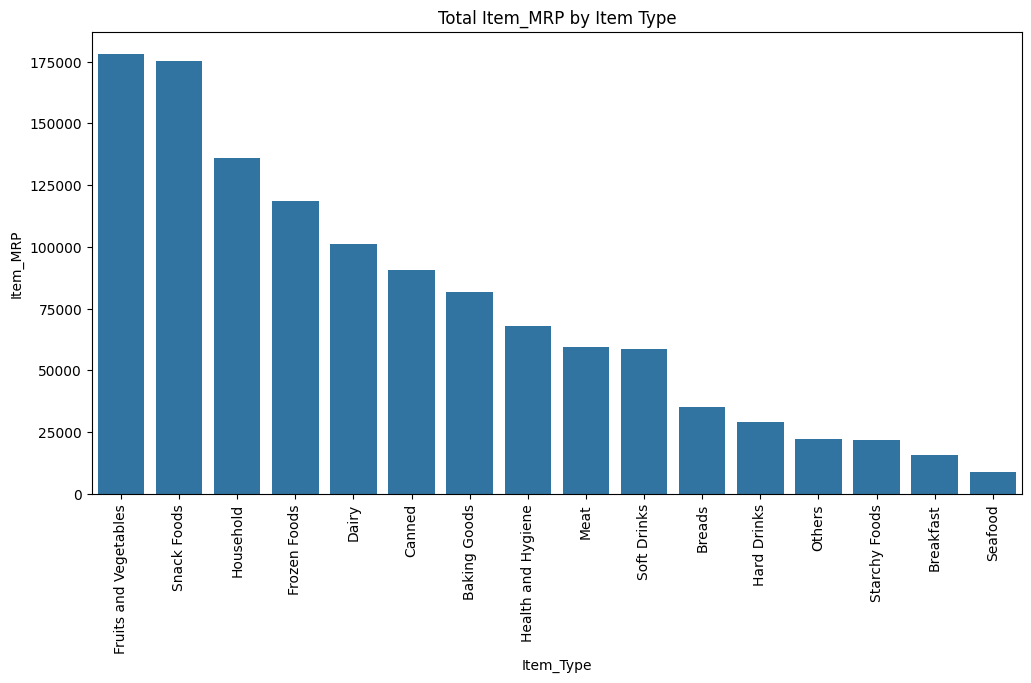

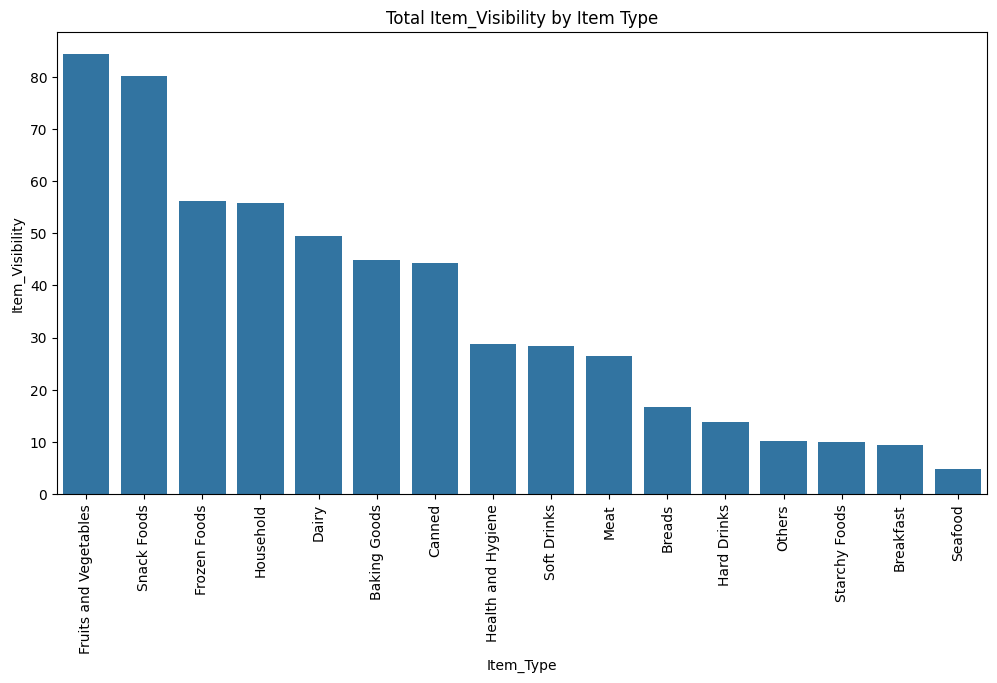

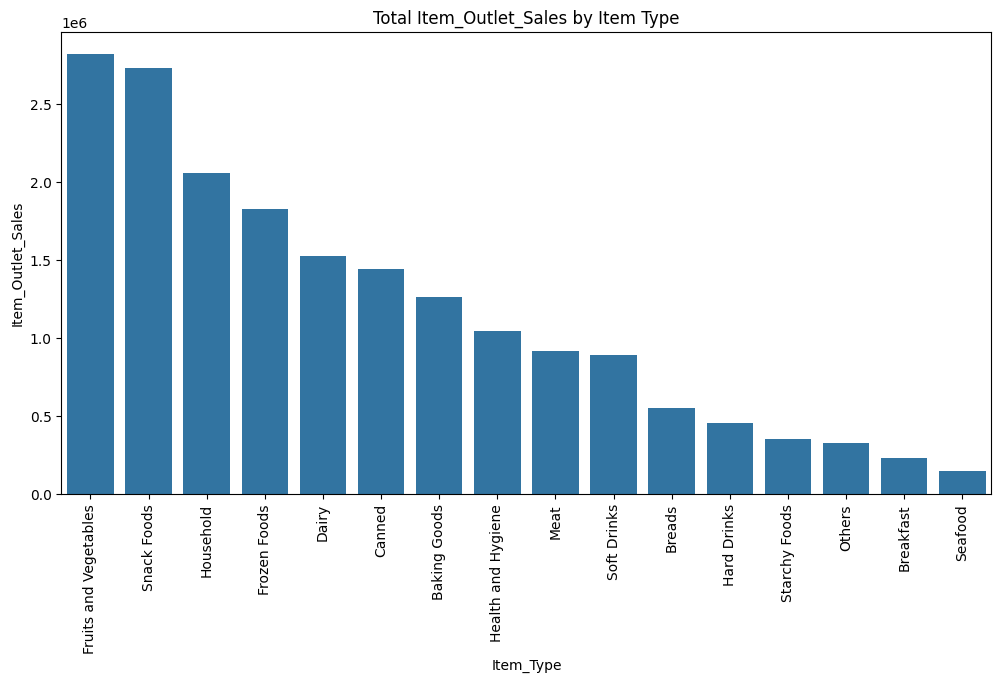

In [17]:
for i in ["Item_Weight","Item_MRP","Item_Visibility","Item_Outlet_Sales"]:
    plt.figure(figsize=(12, 6))
    sns.barplot(x="Item_Type", y=i, data=data[["Item_Type",i]].groupby(["Item_Type"]).sum().sort_values([i],ascending=False
                                                                                                        ))
    plt.xticks(rotation=90)
    plt.title(f'Total {i} by Item Type')
    plt.show()


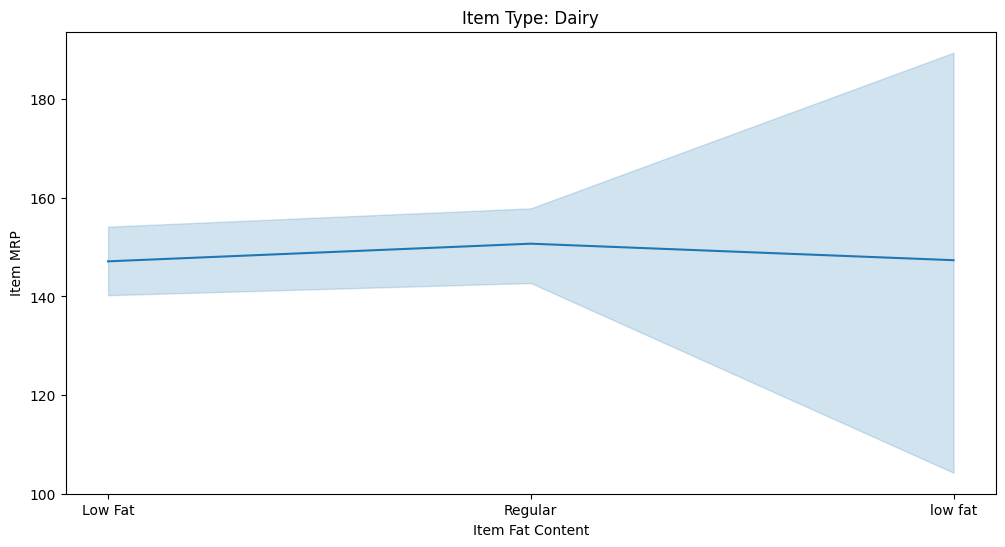

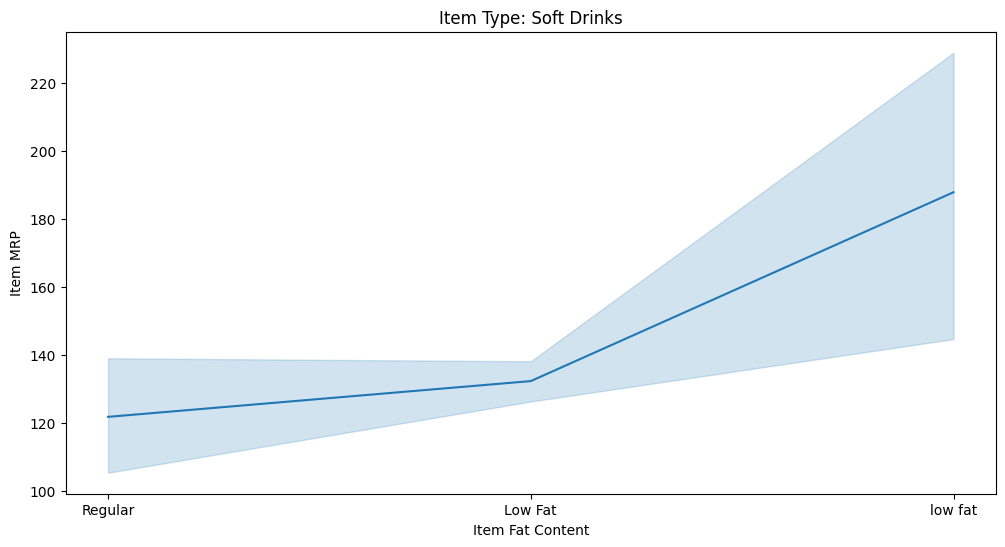

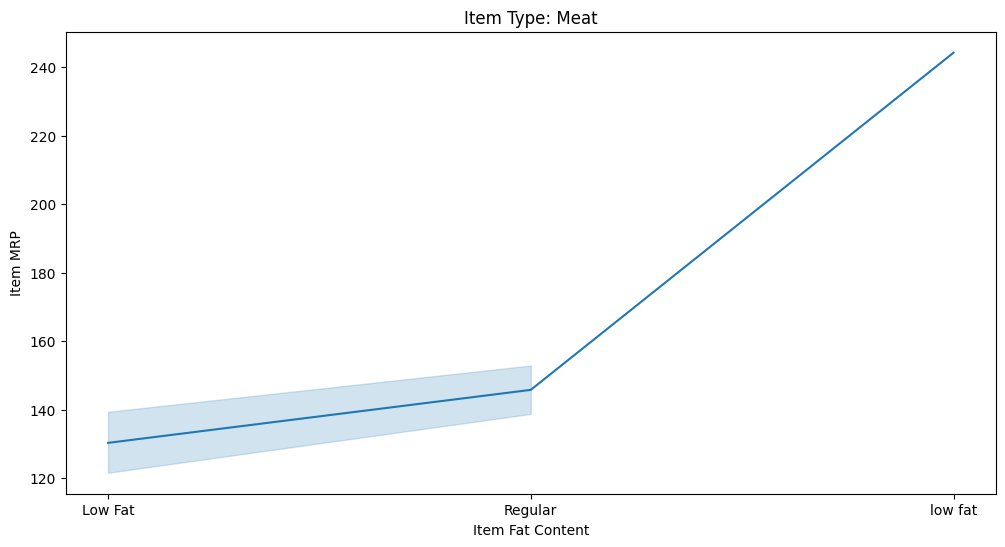

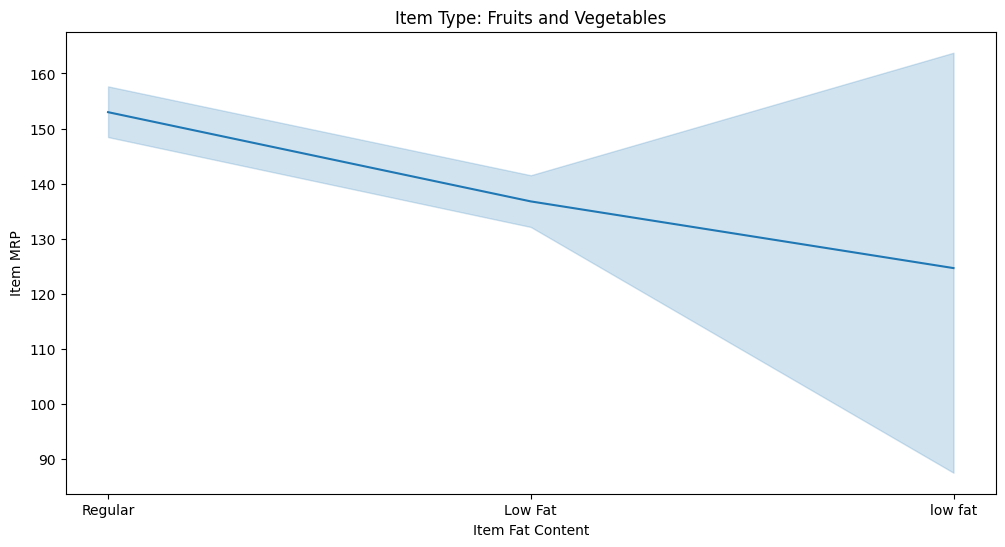

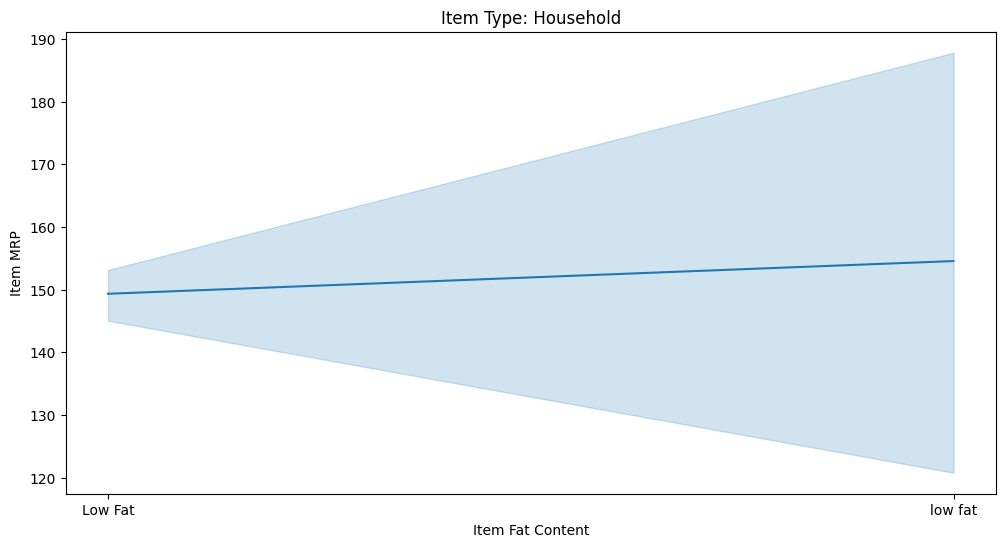

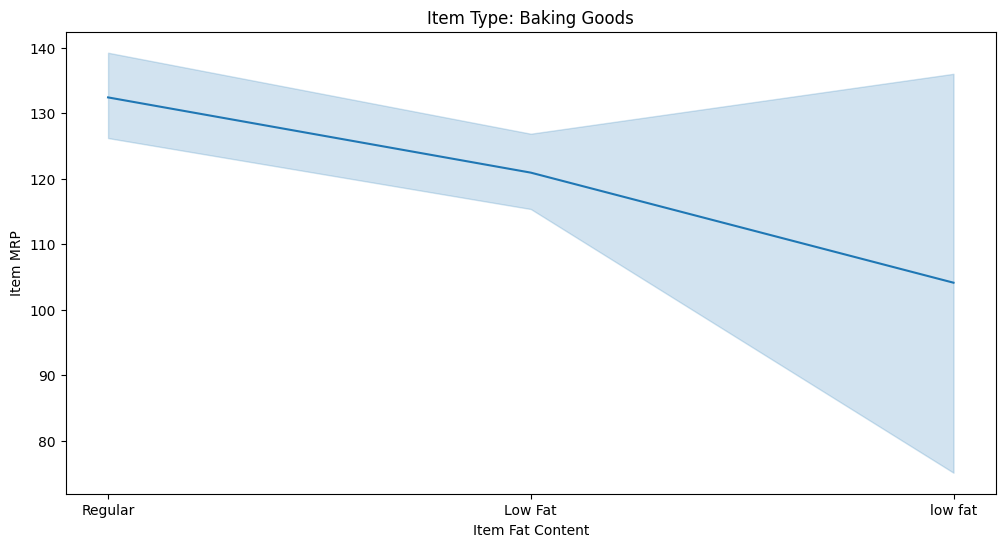

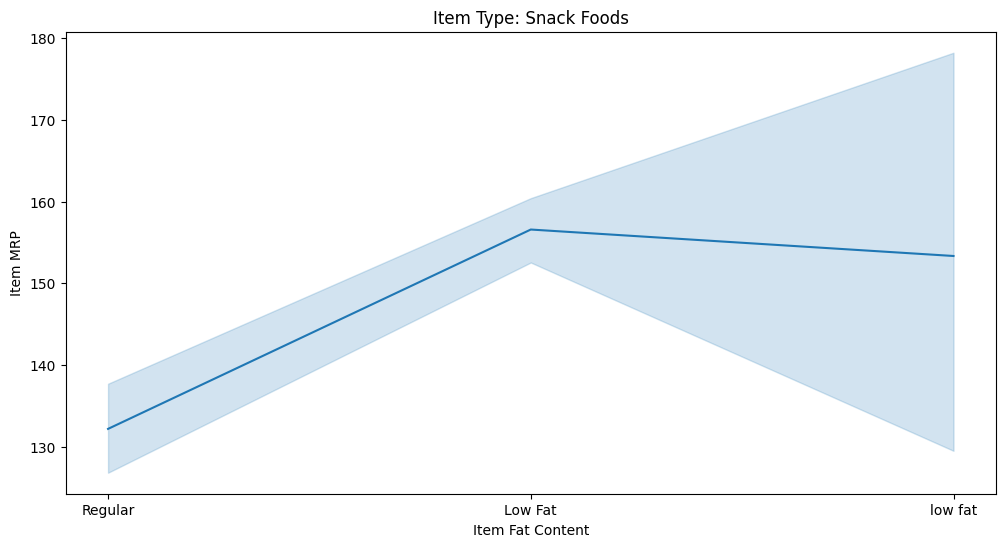

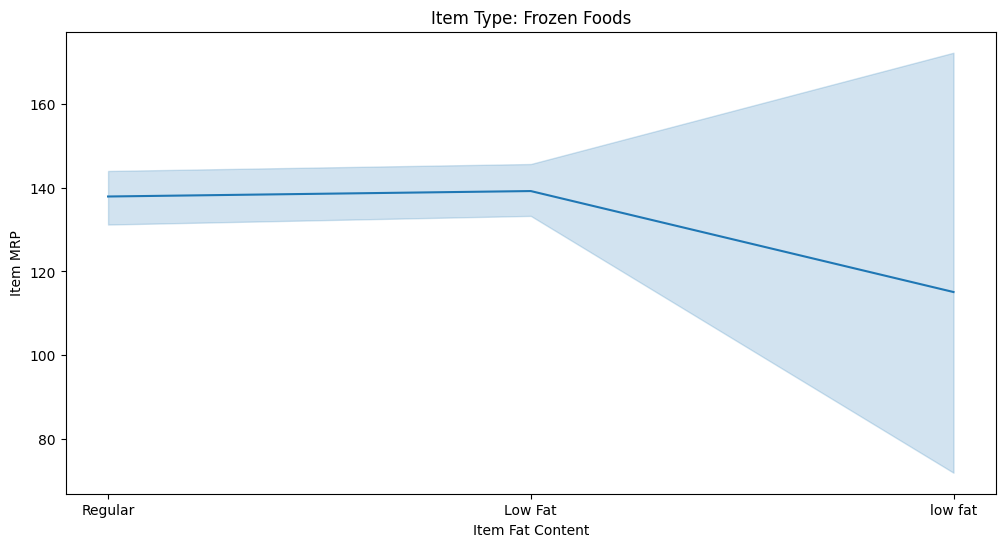

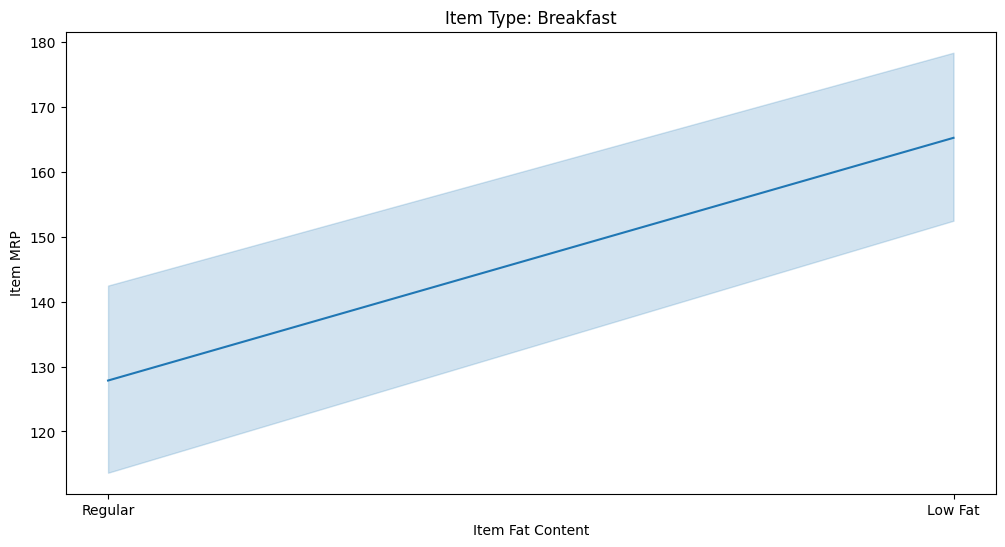

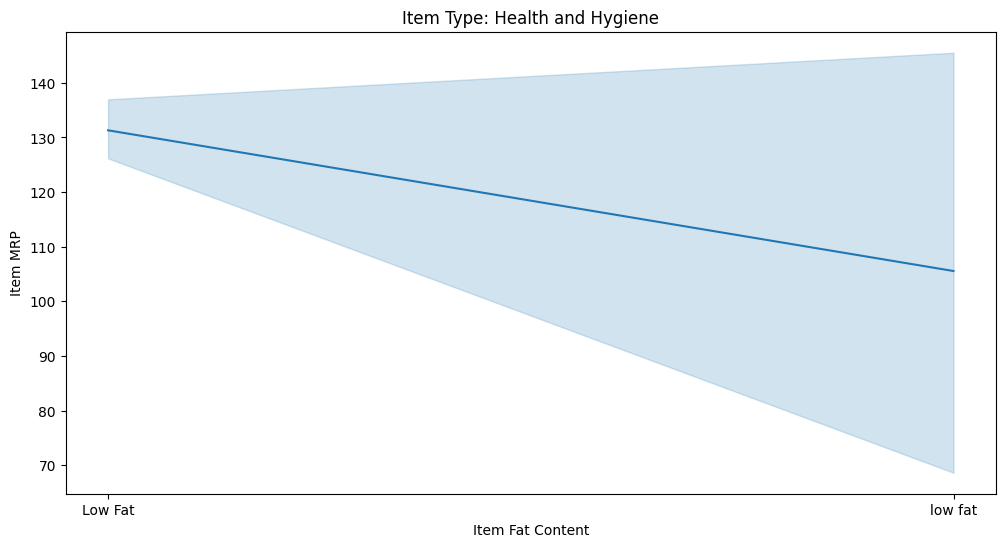

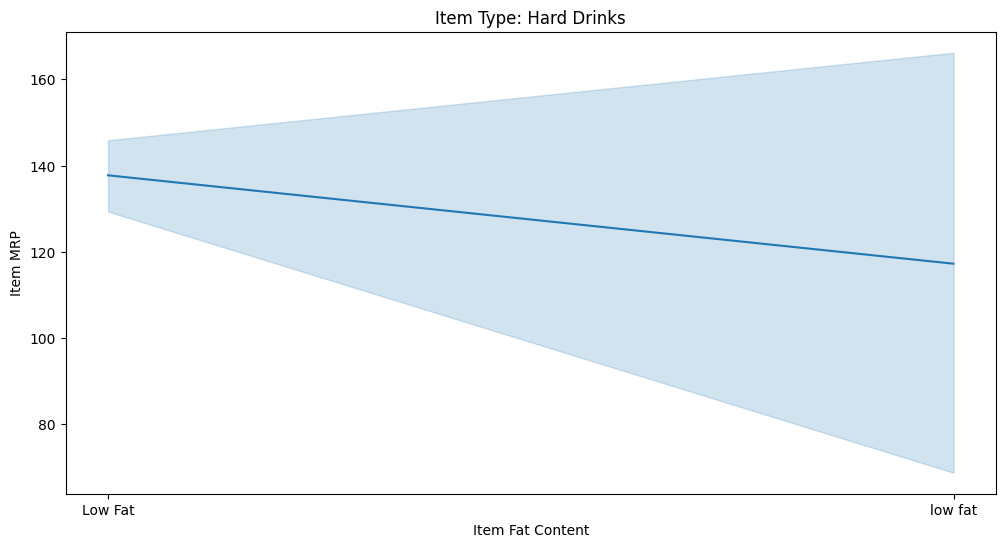

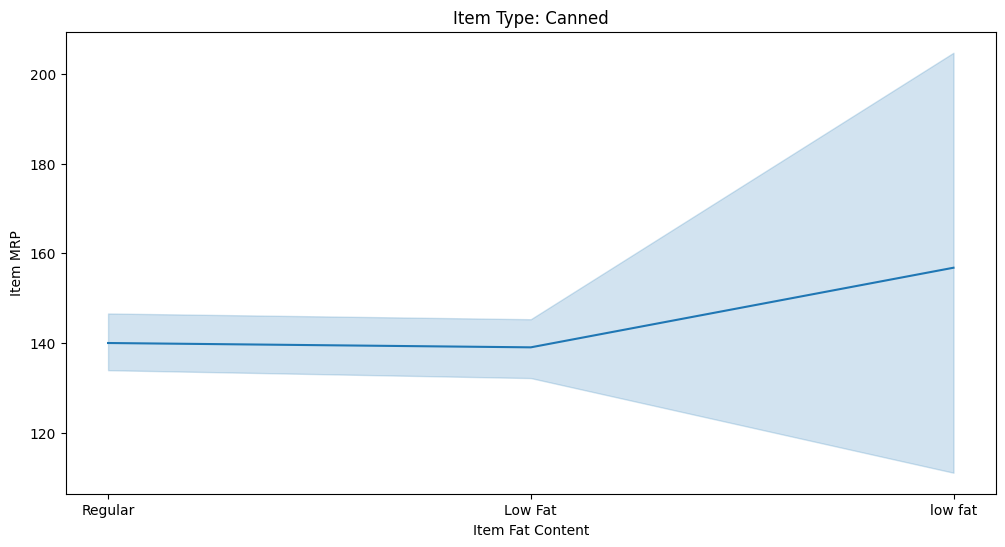

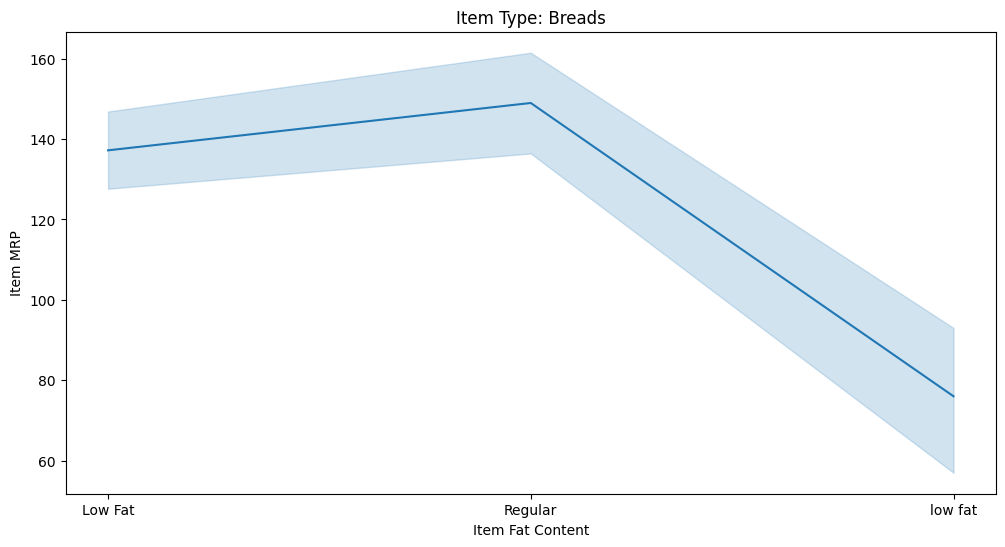

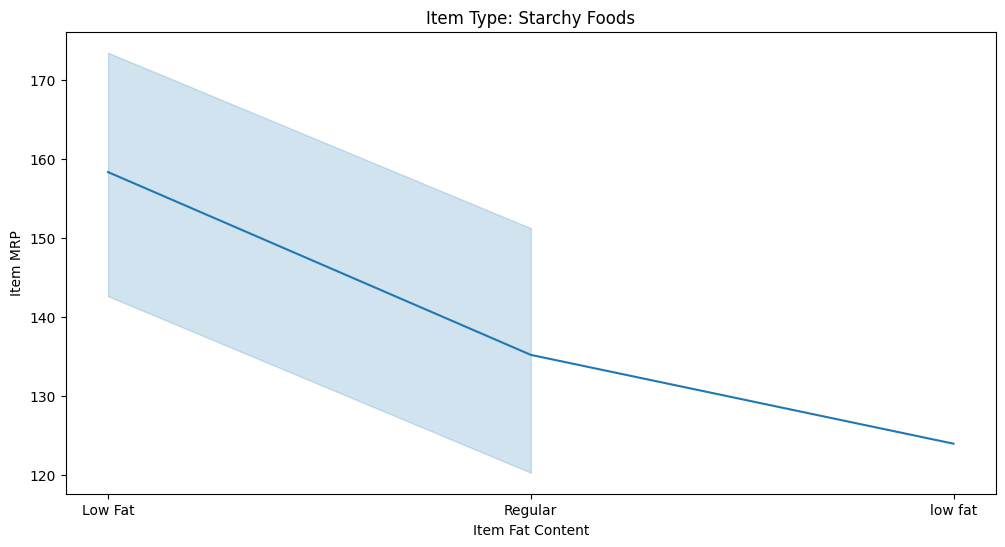

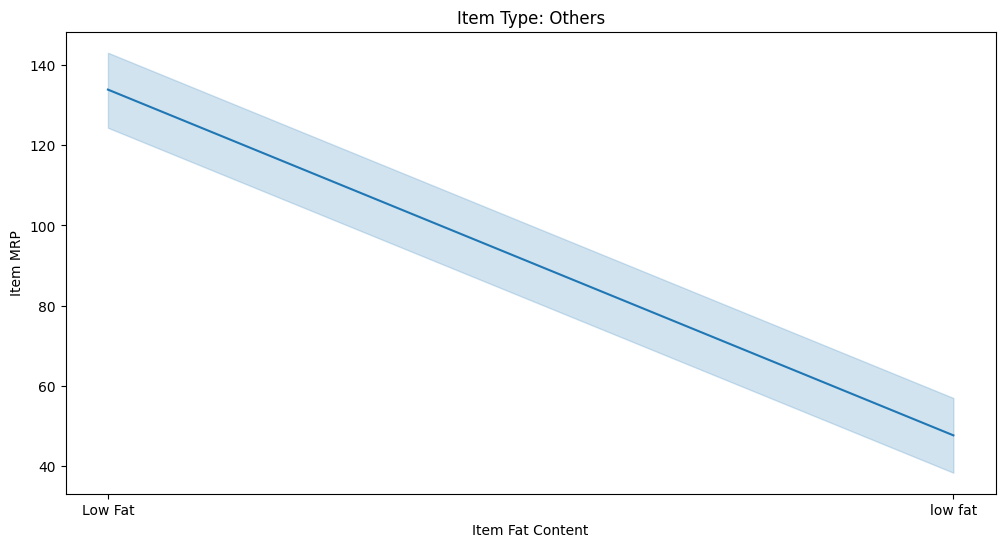

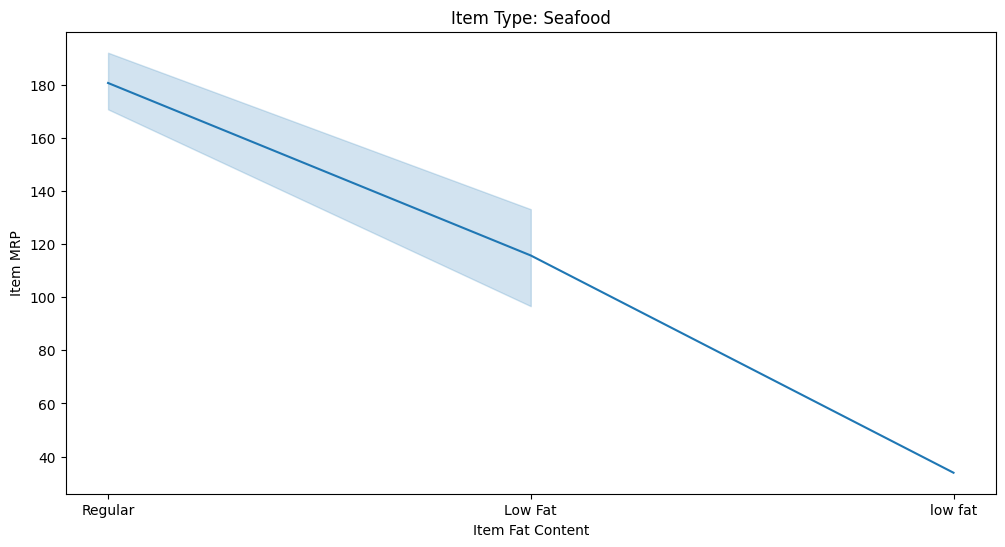

In [18]:
item_types = data["Item_Type"].unique()

for i, item_type in enumerate(item_types):
    plt.figure(figsize=(12, 6))
    sns.lineplot(y="Item_MRP", x="Item_Fat_Content", data=data[data["Item_Type"] == item_type])
    plt.xlabel("Item Fat Content")
    plt.ylabel("Item MRP")
    plt.title(f"Item Type: {item_type}")
    plt.show()

Text(0.5, 0, 'Outlet Type')

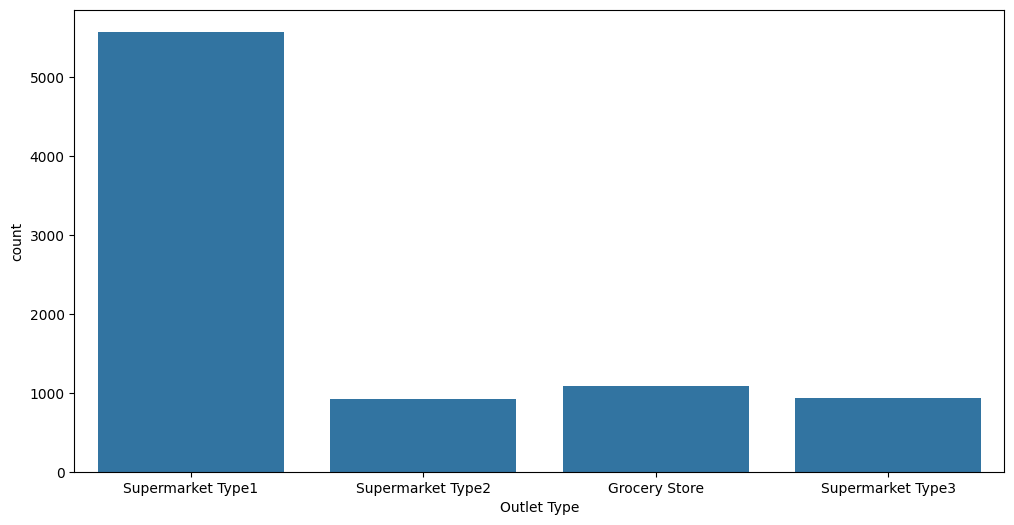

In [19]:
plt.figure(figsize=(12,6))
sns.countplot(data=data,x="Outlet_Type")
plt.xlabel("Count of Outlet Type")
plt.xlabel("Outlet Type")

Text(0.5, 0, 'Outlet Location Type')

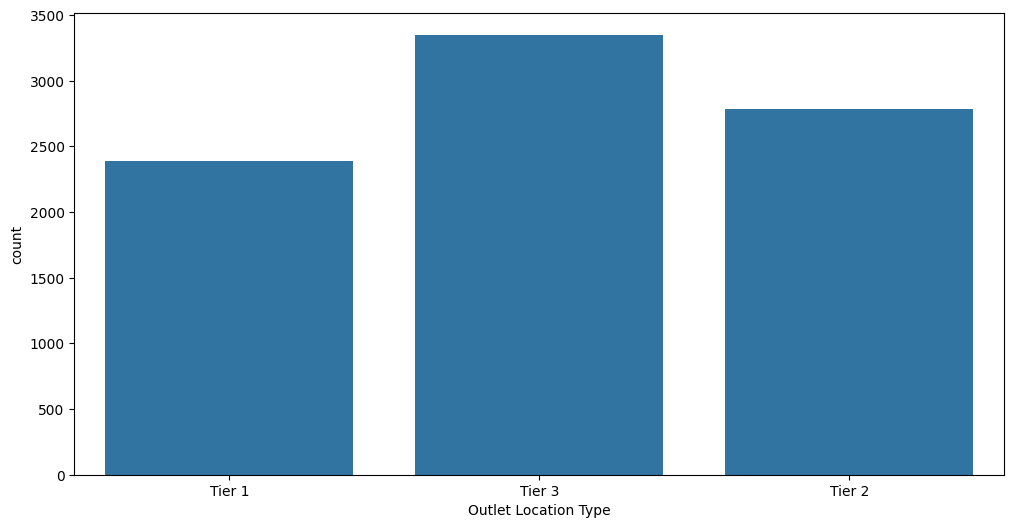

In [20]:
plt.figure(figsize=(12,6))
sns.countplot(data=data,x="Outlet_Location_Type")
plt.xlabel("Count of Outlet Location Type")
plt.xlabel("Outlet Location Type")

<Axes: xlabel='Outlet_Identifier', ylabel='Outlet_Establishment_Year'>

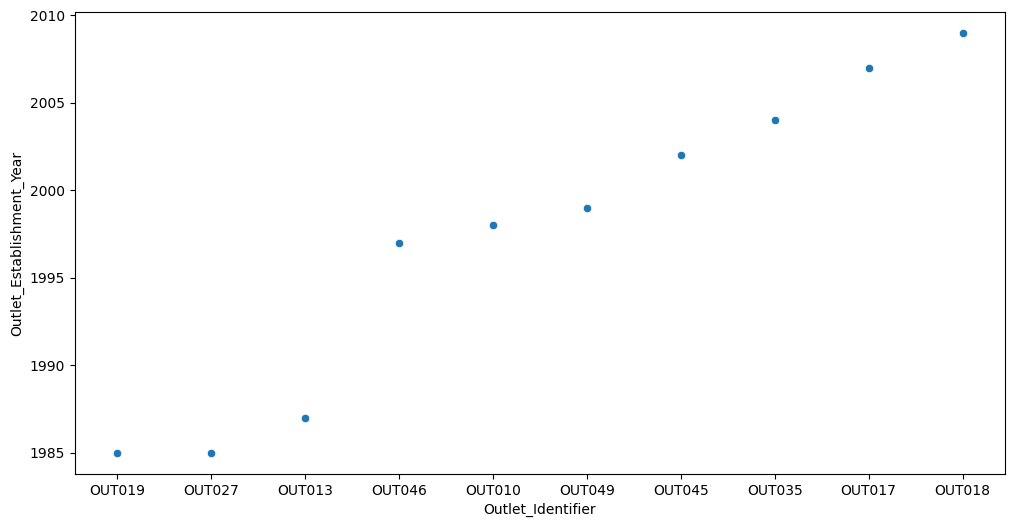

In [21]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=data.groupby(["Outlet_Establishment_Year","Outlet_Identifier"]).sum(),x="Outlet_Identifier",y="Outlet_Establishment_Year")

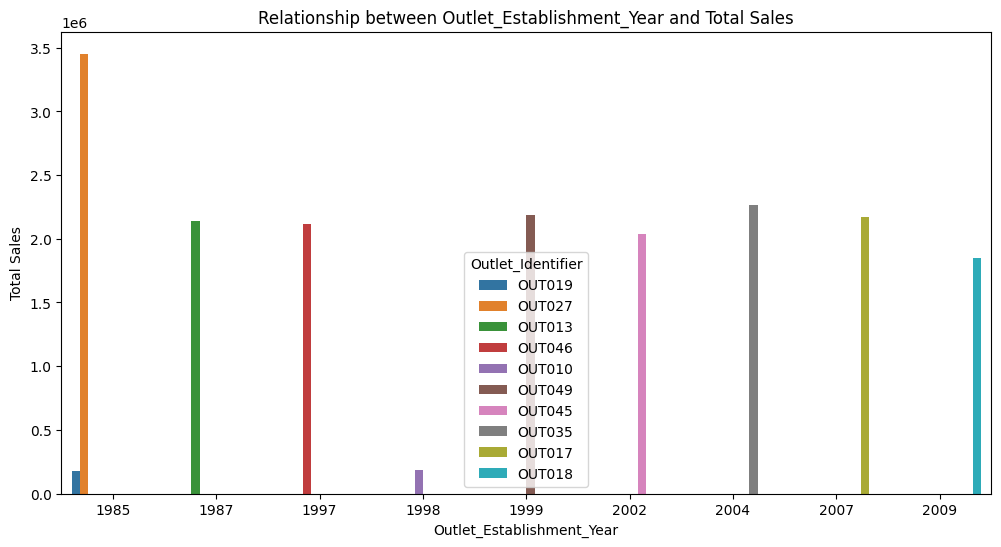

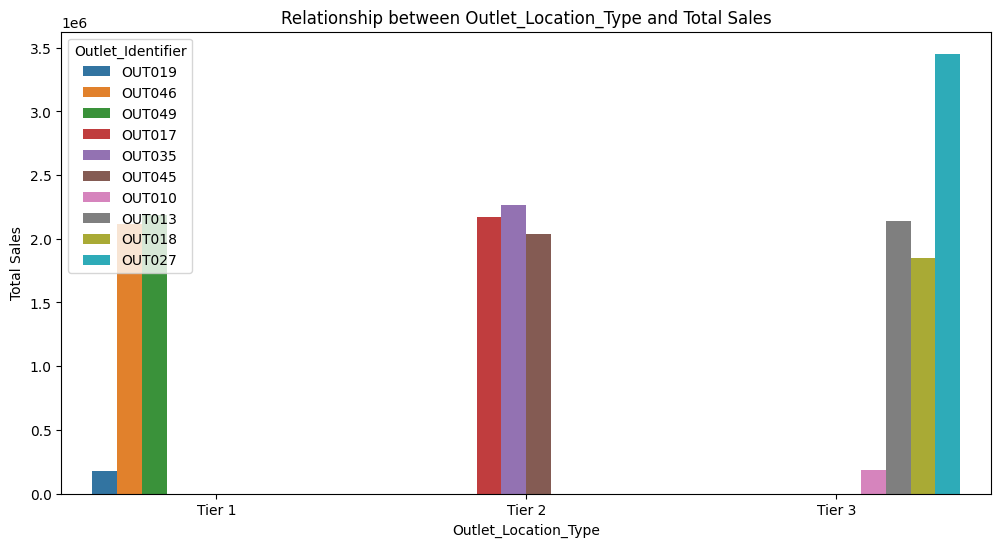

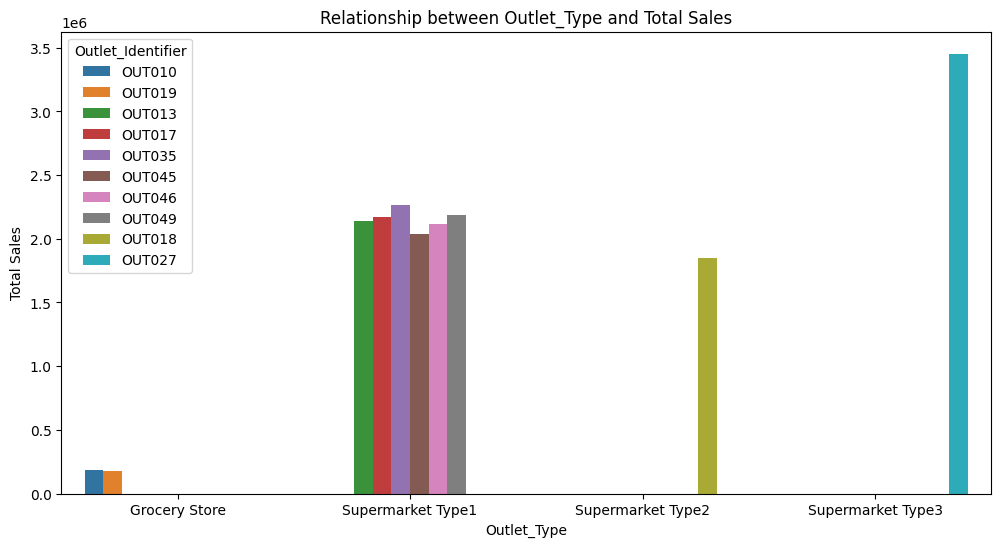

In [22]:
for i in ["Outlet_Establishment_Year", "Outlet_Location_Type", "Outlet_Type"]:
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=data.groupby([i, "Outlet_Identifier"]).sum(),
        hue="Outlet_Identifier",
        x=i,
        y="Item_Outlet_Sales",
    )
    plt.xlabel(i)
    plt.ylabel("Total Sales")
    plt.title(f"Relationship between {i} and Total Sales")
    plt.show()

In [23]:
data["Outlet_Identifier"].unique()

array(['OUT049', 'OUT018', 'OUT010', 'OUT013', 'OUT027', 'OUT045',
       'OUT017', 'OUT046', 'OUT035', 'OUT019'], dtype=object)